In [1]:
import vgg16

In [2]:
vgg16.data_dir='vgg16/'
vgg16.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [2]:
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import tensorflow as tf

(700, 393, 3)


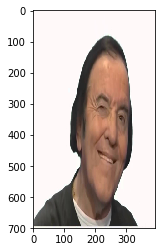

In [3]:
def load_image(filename,max_size=300):
    image=PIL.Image.open(filename)
    size=np.array(np.shape(image))[:2]
    scale_factor=max_size/np.max(size)
    
    new_size=(size*scale_factor).astype(int)
    
    image=image.resize(new_size,PIL.Image.LANCZOS)
    return np.float32(image)    
#test        
image_test=load_image('wow.jpg',max_size=700)
print(image_test.shape)        

plt.imshow(image_test/255)
plt.show()

In [4]:
def save_image(filename,image):
    with open(filename,"wb") as fp: 
        image=image.astype(np.uint8)
        PIL.Image.fromarray(image).save(fp, 'jpeg')
save_image("starry_night2.jpg",image_test)    

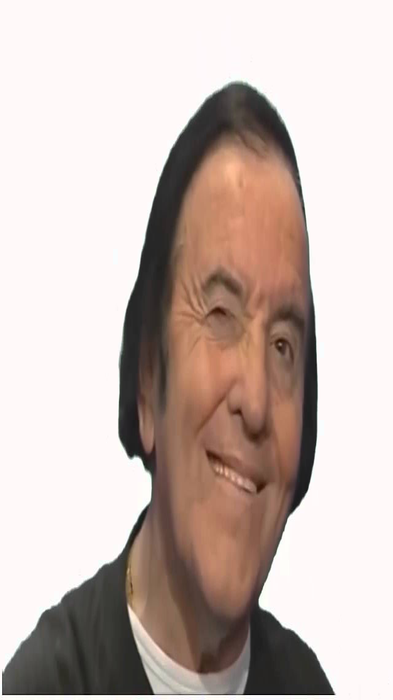

In [5]:
def plot_image(image):
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))
plot_image(image_test)    

In [6]:
def mean_squared_error(a,b):
    return tf.reduce_sum(tf.square(a-b))

def create_content_loss(session,model,content_image,layer_ids):
    feed_dict=model.create_feed_dict(image=content_image)
    layers=model.get_layer_tensors(layer_ids)
    values=session.run(layers,feed_dict=feed_dict)
    with model.graph.as_default():
        layer_losses=[]
        for value,layer in zip(values,layers):
            value_const=tf.constant(value)
            loss=mean_squared_error(layer,value_const)
            
        layer_losses.append(loss)
    total_loss=tf.reduce_mean(layer_losses)
    return total_loss
                                                

In [12]:
def gram_matrix(tensor):
    shape=np.shape(tensor)
    num_channels=int(shape[3])
    matrix=tf.reshape(tensor,[-1,num_channels])
    gram=tf.matmul(tf.transpose(matrix),matrix)
    return gram
def create_style_loss(session,model,style_image,layer_ids):
    feed_dict=model.create_feed_dict(image=style_image)
    layers=model.get_layer_tensors(layer_ids)
    with model.graph.as_default():
        gram_layers=[gram_matrix(layer) for layer in layers]
        values=session.run(gram_layers,feed_dict=feed_dict)
        layer_losses=[]
        for val,layer in zip(values,gram_layers):
            
            loss=mean_squared_error(layer,val )
            layer_losses.append(loss)
        total_loss=tf.reduce_mean(layer_losses)
    return total_loss
        
        
    
    
    

In [13]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [14]:
def style_transfer(content_image,style_image,
                   content_layer_ids,style_layer_ids,weight_content=1.5,weight_style=10.0,weight_denoise=0.3,
                  num_iterations=120,step_size=10.0):
    
    
    model=vgg16.VGG16()
    
    session=tf.InteractiveSession(graph=model.graph)
    
    print("content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()
    
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    loss_content=create_content_loss(session=session,model=model,content_image=content_image,layer_ids=content_layer_ids)
    loss_style=create_style_loss(session=session,model=model,style_image=style_image,layer_ids=style_layer_ids)
    loss_denoise=create_denoise_loss(model=model)
    
    adj_content=tf.Variable(1e-10,name="adj_content")
    adj_style=tf.Variable(1e-10,name="adj_style")
    adj_denoise=tf.Variable(1e-10,name="adj_denoise")
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])
    update_adj_content=adj_content.assign(1.0/(loss_content+1e-10))
    update_adj_style=adj_style.assign(1.0/(loss_style+1e-10))
    update_adj_denoise=adj_denoise.assign(1.0/(loss_denoise+1e-10))
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
    gradient = tf.gradients(loss_combined, model.input)
    run_list = [gradient, update_adj_content, update_adj_style, 
                update_adj_denoise]
    
    mixed_image=np.random.rand(*content_image.shape)+128
    for i in range(num_iterations):
        feed_dict = model.create_feed_dict(image=mixed_image)
        grad, adj_content_val, adj_style_val, adj_denoise_val=session.run(run_list,feed_dict=feed_dict)
        grad = np.squeeze(grad)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        mixed_image-=grad*step_size_scaled
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        print(". ", end="")
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_image(content_image)
            plot_image(style_image)
            plot_image(mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image
                      
        

        
        
        
        
        
        
    
    
    
    
    
    
    
    

In [15]:
content_filename = 'wow.jpg'
content_image = load_image(content_filename, max_size=300)
style_filename = 'starrynight.jpg'
style_image = load_image(style_filename, max_size=300)
content_layer_ids = [4]
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 5.35e-17, Style: 2.34e-32, Denoise: 9.97e-06


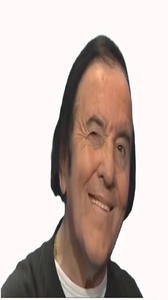

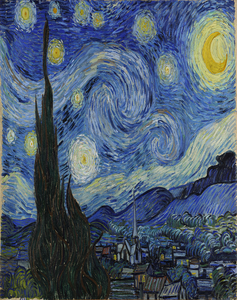

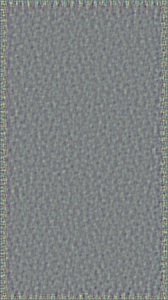

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 4.01e-17, Style: 2.37e-31, Denoise: 2.41e-07


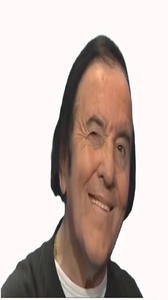

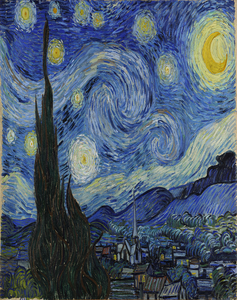

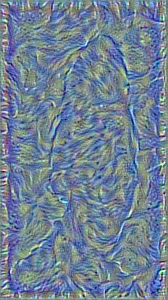

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 3.77e-17, Style: 3.34e-31, Denoise: 2.05e-07


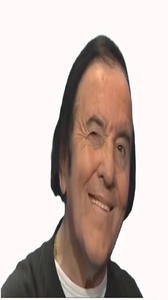

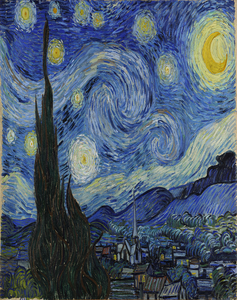

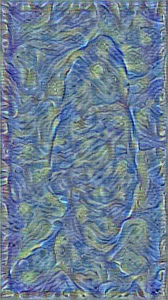

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 3.97e-17, Style: 3.26e-31, Denoise: 2.25e-07


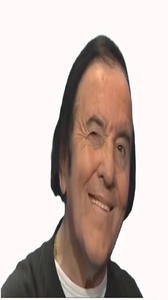

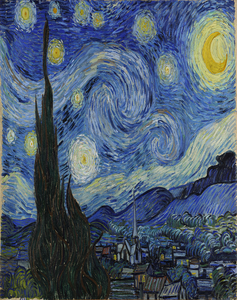

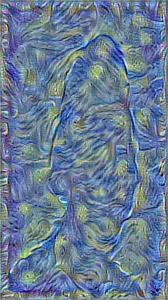

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 3.87e-17, Style: 3.22e-31, Denoise: 2.07e-07


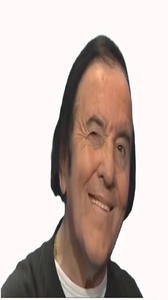

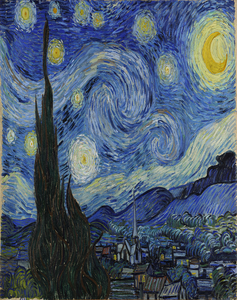

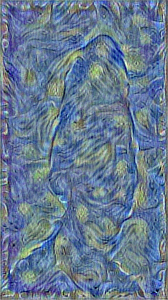

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 3.92e-17, Style: 3.57e-31, Denoise: 2.10e-07


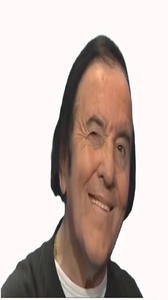

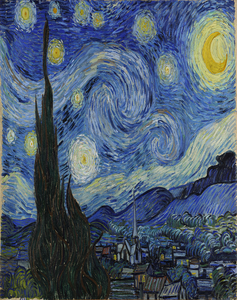

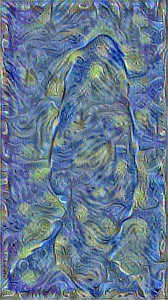

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 4.12e-17, Style: 2.50e-31, Denoise: 2.29e-07


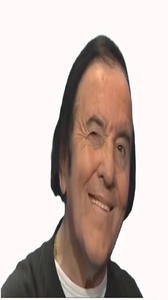

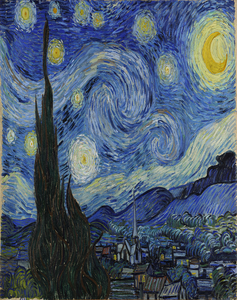

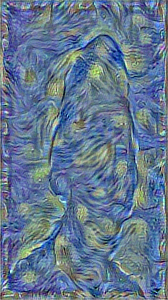


Final image:


NameError: name 'plot_image_big' is not defined

In [16]:


# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)